In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as pl
pl.rc("figure", facecolor="gray")
pl.rc('text', usetex=True)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns
import pandas as pd
sns.set()
sns.set_style("whitegrid",{'axes.grid' : True,'axes.edgecolor' : 'k'})

build lower triangular matrix

In [2]:
def make_theta(diag_value,delay_value,triag_value,N):
    return np.diag([diag_value]*N,k=0)+np.diag([delay_value]*(N-1),k=-1)+np.tril(triag_value*np.ones((N,N)),k=-2)
make_theta(1,2,3,4)

array([[1., 0., 0., 0.],
       [2., 1., 0., 0.],
       [3., 2., 1., 0.],
       [3., 3., 2., 1.]])

In [3]:
N=100 #network size

Create initial condition ensemble approximately uniform on unit hypersphere:

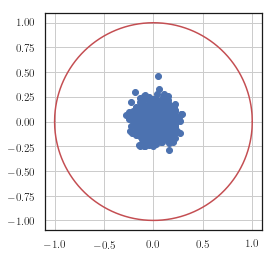

In [4]:
num_points=1000
np.random.seed(4)
x0_data=np.random.randn(num_points*N).reshape((N,num_points))
x0_data=x0_data/(la.norm(x0_data,axis=0)[np.newaxis,:])
# print("init |data")
# print(x0_data)
fig,ax=pl.subplots(1,1)
ax.scatter(x0_data[0,:],x0_data[1,:]) #plot 2D projection
r=1.0
xvec=np.linspace(-r,r,1000)
ax.plot(xvec,np.sqrt(r**2-xvec**2),'r')
ax.plot(xvec,-np.sqrt(r**2-xvec**2),'r')
ax.set_ylim(ax.get_xlim())
ax.set_aspect(aspect=1.0/ax.get_data_ratio())

Plot transients over various matrices

In [5]:
d=0
avec=[0.95,1.0,1.05]
bvec=[0,0.005]
num_steps=150
df_std_all=pd.DataFrame()
df_norm_all=pd.DataFrame()
for b in bvec:
    for a in avec:
        df_std=pd.DataFrame(np.array([np.std(np.linalg.matrix_power(make_theta(d,a,b,N),k) @ x0_data,axis=1) for k in np.arange(num_steps)]).T,columns=(np.arange(num_steps)).tolist()).melt(var_name='iter',value_name='x')              
        df_norm=pd.DataFrame(np.array([la.norm(np.linalg.matrix_power(make_theta(d,a,b,N),k) @ x0_data,axis=0) for k in np.arange(num_steps)]).T,columns=(np.arange(num_steps)).tolist()).melt(var_name='iter',value_name='x')              
        df_std[r'$\alpha$']=a
        df_std[r'$\beta$']=b
        df_norm[r'$\alpha$']=a
        df_norm[r'$\beta$']=b
        df_std_all=df_std_all.append(df_std).reset_index(drop=True)
        df_norm_all=df_norm_all.append(df_norm).reset_index(drop=True)
df_std_all.head()

,iter,x,$\alpha$,$\beta$
0,0,0.095557,0.95,0.0
1,0,0.099261,0.95,0.0
2,0,0.097620,0.95,0.0
3,0,0.100146,0.95,0.0
4,0,0.098375,0.95,0.0


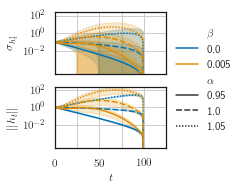

In [6]:
fig,ax=pl.subplots(2,1,figsize=(2.0,2.5))#ensemble statistics
dfs=(df_std_all,df_norm_all)
leg_str=(False,'full')
tmax=125 if d==0 else num_steps
xticklabels=[0,25,50,75,100,125]
yticklabels=[1e-2,1e0,1e2]

for pit,df in enumerate(dfs):
    ax[pit].set(yscale="log")
    sns.lineplot(ax=ax[pit],x='iter',y='x',data=df,style=r'$\alpha$',hue=r'$\beta$',ci='sd',legend=leg_str[pit],palette=sns.color_palette("colorblind", 2))
    ax[pit].set_ylim(2.3e-5,2.3e2)
    ax[pit].set_xlim(0,tmax)
    ax[pit].set_xticks(xticklabels)
    ax[pit].set_yticks(yticklabels)
ax[0].set_xticklabels([])
ax[0].set_xlabel('')
ax[0].set_ylabel(r'$\sigma_{h^i_t}$')
ax[pit].set_ylabel(r'$\left|\left|h_t\right|\right|$')
ax[pit].set_xticklabels([r'$0$' ,'',r'$50$','',r'$100$',''])
ax[pit].set_xlabel(r'$t$');
ax[pit].legend(bbox_to_anchor=(1.0,2.1),frameon=False)
# fig.savefig('fig1_theory_panelb_d0.pdf',format='pdf',dpi=300,bbox_inches='tight')

Plot Fisher memory curves

In [7]:
def compute_Jk(alpha,beta,rho,n_steps,num_steps,N):
    M = rho * np.eye(N)
    for i in range(N-1):
        M[i+1,i] = alpha
    for i in range(N-2):
        for j in range(i+1):
            M[i+2,j] = beta
    M_k = M.copy()
    e_k = np.zeros((4*N+1,N))
    e_k[0,0] = 1
    C_n = np.eye(N)
    for t in range(4*N): 
        e_k[t+1,:] = M.dot(e_k[t,:])
    M_k = M.copy()
    for t in range(n_steps):
        C_n = M.dot(C_n).dot(M.T) + np.eye(N)
    J_tot=0
    J = np.zeros(num_steps)
    for i in range(num_steps):
        J[i] = np.sum(e_k[i,:] * np.linalg.solve(C_n,e_k[i,:]))
        J_tot += J[i]
    return J

In [8]:
dvec=[0,0.2]
n_steps=int(1e4)
J_store=np.empty((len(avec),len(bvec),len(dvec)),dtype=object)
for ait,alpha in enumerate(avec[::-1]):
    for bit,beta in enumerate(bvec[::-1]):
        for dit,d in enumerate(dvec[::-1]):
            J_store[ait,bit,dit] = compute_Jk(alpha,beta,d,n_steps,num_steps,N)
            print(f"J_tot: {np.sum(J_store[ait,bit,dit])}, alpha: {alpha}, beta: {beta}, d: {d}" )

J_tot: 20.32295558140331, alpha: 1.05, beta: 0.005, d: 0.2
J_tot: 12.086536304234857, alpha: 1.05, beta: 0.005, d: 0
J_tot: 20.328096176553625, alpha: 1.05, beta: 0, d: 0.2
J_tot: 12.08727212122481, alpha: 1.05, beta: 0, d: 0
J_tot: 16.1637115854401, alpha: 1.0, beta: 0.005, d: 0.2
J_tot: 5.301425802978977, alpha: 1.0, beta: 0.005, d: 0
J_tot: 17.132327989761464, alpha: 1.0, beta: 0, d: 0.2
J_tot: 5.18737751763962, alpha: 1.0, beta: 0, d: 0
J_tot: 12.094319320360942, alpha: 0.95, beta: 0.005, d: 0.2
J_tot: 3.175767594604019, alpha: 0.95, beta: 0.005, d: 0
J_tot: 11.939270436426913, alpha: 0.95, beta: 0, d: 0.2
J_tot: 3.0327020748310467, alpha: 0.95, beta: 0, d: 0


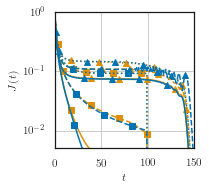

In [9]:
mkr=['^','s']
sty=[':','--','-']
col=sns.color_palette("colorblind", 2)[::-1]

fig,ax=pl.subplots(1,1,figsize=(2.5,2.5))
for ait,alpha in enumerate(avec[::-1]):
    for bit,beta in enumerate(bvec[::-1]):
        for dit,d in enumerate(dvec[::-1]):
            ax.semilogy(J_store[ait,bit,dit],linestyle=sty[ait],
                         marker=mkr[dit],color=col[bit],
                         markevery=(int(29*np.random.rand(1)),30))
ax.set_ylim([5*1e-3,1])
# ax.set_ylim([5*1e-6,1])
ax.set_xlim([0,150])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$J(t)$");
# fig.savefig("J_tt.pdf",bbox_inches='tight')